In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [5]:
print(train_data.shape, test_data.shape)

(159571, 8) (153164, 2)


**PREPROCCESING**


**1. LOWERCASING THE TEXT**

In [6]:
train_data.comment_text = [text.lower() for text in train_data.comment_text]
test_data.comment_text = [text.lower() for text in test_data.comment_text]

**2. TOKENIZATION**

In [7]:
from nltk.tokenize import word_tokenize
train_data.comment_text = [word_tokenize(text) for text in train_data.comment_text]
test_data.comment_text = [word_tokenize(text) for text in test_data.comment_text]

**3. REMOVING STOP WORDS**

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_data.comment_text = [word for word in train_data.comment_text if not word in stop]
test_data.comment_text = [word for word in test_data.comment_text if not word in stop]

**4. STEMMING AND LEMMATIZATION**

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stem = PorterStemmer()
lem = WordNetLemmatizer()

def stem_lem(data):
    lemmatized = []
    for text in data:
        final = []
        for word in text:
            #Check if the recursion depth does not exceed
            if len(word) < 990:
                stem.stem(word)
                final.append(lem.lemmatize(word))
        lemmatized.append(final)
    return lemmatized

train_data.comment_text = stem_lem(train_data.comment_text)
test_data.comment_text = stem_lem(test_data.comment_text)

**BULDING RNN WITH TENSORFLOW**

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, Bidirectional, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Sequential
from keras.preprocessing import text
from keras.utils import pad_sequences

In [11]:
X_train = train_data["comment_text"]
y_train = train_data[["toxic", 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_test = test_data["comment_text"]

tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_l = 100

X_train = pad_sequences(X_train, maxlen = max_l)
X_test = pad_sequences(X_test, maxlen = max_l)

In [32]:
model = Sequential()
model.add(Embedding(20000, 50, input_shape = (100, )))
model.add(Bidirectional(LSTM(50, dropout=0.1)))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

In [33]:
history = model.fit(X_train, y_train, epochs = 2, validation_split = 0.1, batch_size = 32, callbacks=[tensorboard])

Epoch 1/2


2022-08-01 01:57:42.829225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 01:57:43.141880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 01:57:43.153125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 01:57:43.501650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 01:57:43.517951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4488/4488 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9594

2022-08-01 02:01:22.463584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 02:01:22.558460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 02:01:22.566698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4488/4488 [==============================] - 234s 51ms/step - loss: 0.0714 - accuracy: 0.9594 - val_loss: 0.0528 - val_accuracy: 0.9939
Epoch 2/2
4488/4488 [==============================] - 230s 51ms/step - loss: 0.0486 - accuracy: 0.9922 - val_loss: 0.0517 - val_accuracy: 0.9940


Text(0, 0.5, 'accuracy')

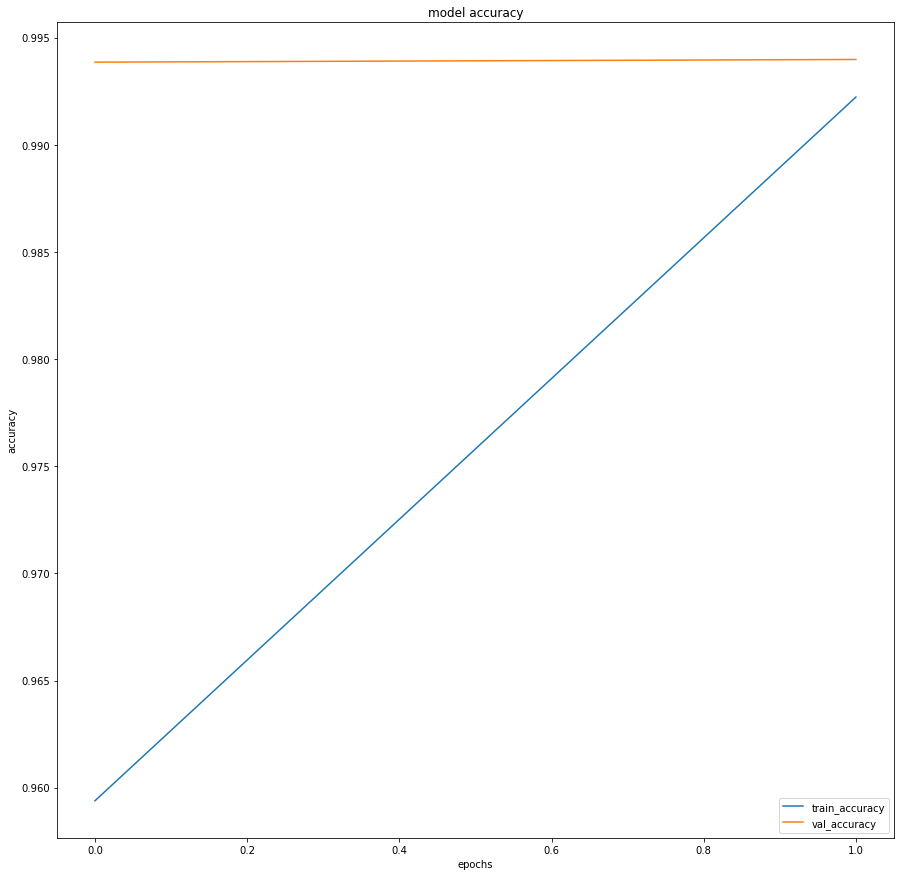

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 15))
plt.title('model accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

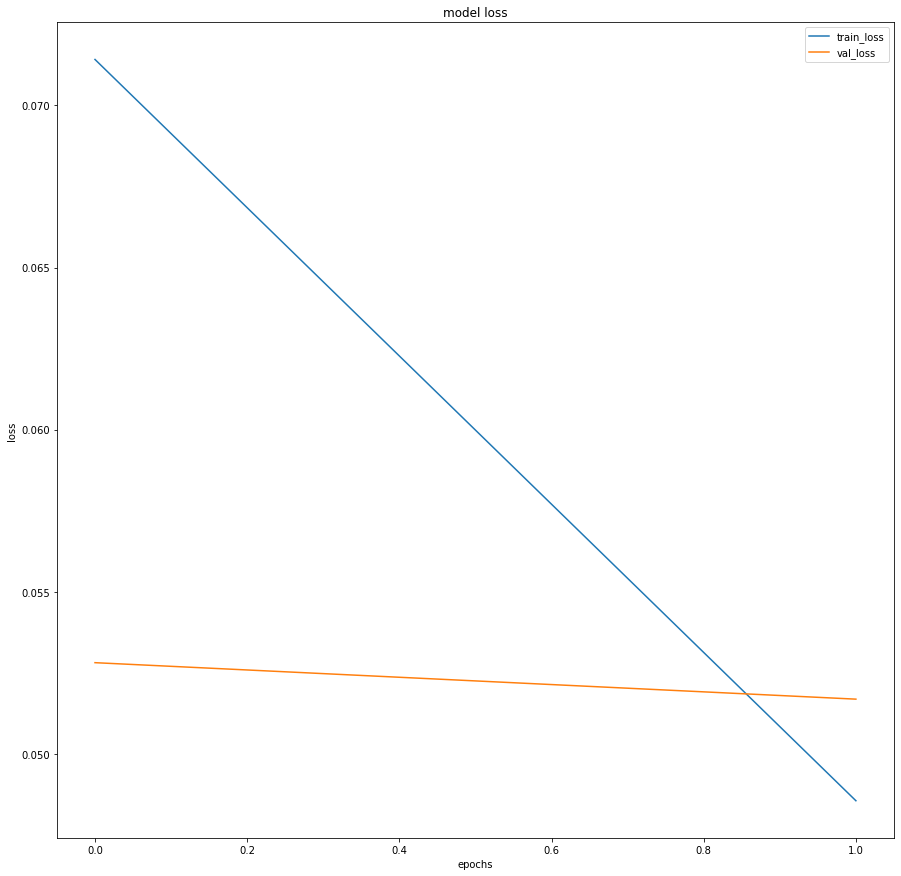

In [35]:
plt.figure(figsize= (15, 15))
plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [36]:
predictions = model.predict(X_test)

2022-08-01 02:05:24.992822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 02:05:25.066721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 02:05:25.074928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4787/4787 [==============================] - 106s 22ms/step


In [37]:
df = pd.DataFrame({'id': test_data['id']})
cols = train_data[["toxic", 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
predictions_df = pd.concat([df, pd.DataFrame(predictions, columns = cols.columns)], axis=1)
predictions_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.995640,0.374013,0.966597,0.059201,0.861855,0.222798
1,0000247867823ef7,0.001418,0.000002,0.000103,0.000016,0.000145,0.000052
2,00013b17ad220c46,0.008060,0.000012,0.000545,0.000100,0.000794,0.000269
3,00017563c3f7919a,0.004002,0.000006,0.000222,0.000057,0.000442,0.000147
4,00017695ad8997eb,0.007909,0.000017,0.000551,0.000156,0.000997,0.000360
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.009534,0.000022,0.000612,0.000217,0.001261,0.000462
153160,fffd7a9a6eb32c16,0.012886,0.000016,0.000747,0.000154,0.001175,0.000390
153161,fffda9e8d6fafa9e,0.005817,0.000006,0.000321,0.000061,0.000521,0.000168
153162,fffe8f1340a79fc2,0.016682,0.000028,0.001863,0.000147,0.001382,0.000446
